# セール施策の因果効果分析

本ノートブックでは、アパレルECにおけるセール施策の有効性を、仮想データと差分の差分法（DID）を用いて定量的に評価します。

## 1. 仮想データの生成
セールの有無に応じて価格・販売数が変動する仮想商品データを生成します。

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
n_items = 100
dates = pd.date_range('2024-01-01', periods=60)
records = []

for item_id in range(n_items):
    treated = np.random.choice([0, 1])
    price_base = np.random.uniform(2000, 6000)
    cost_ratio = np.random.uniform(0.4, 0.7)
    avg_units = np.random.poisson(5)

    for date in dates:
        is_after = int(date >= pd.Timestamp('2024-01-31'))
        discount = 0.3 if (treated == 1 and is_after == 1) else 0.0
        price = price_base * (1 - discount)
        units_sold = max(0, round(avg_units + np.random.normal(0, 1)))
        sales_total = price * units_sold
        cost_total = price_base * cost_ratio * units_sold
        profit = sales_total - cost_total
        profit_margin = profit / sales_total if sales_total > 0 else 0

        records.append([
            item_id, treated, is_after, date,
            round(price), units_sold, round(sales_total), round(profit), profit_margin
        ])

df = pd.DataFrame(records, columns=[
    "item_id", "treatment", "post", "date",
    "price", "units", "sales", "profit", "profit_rate"
])

## 2. 可視化と平均値の算出
Before/After × Control/Treatment ごとの平均を指標別に可視化します。

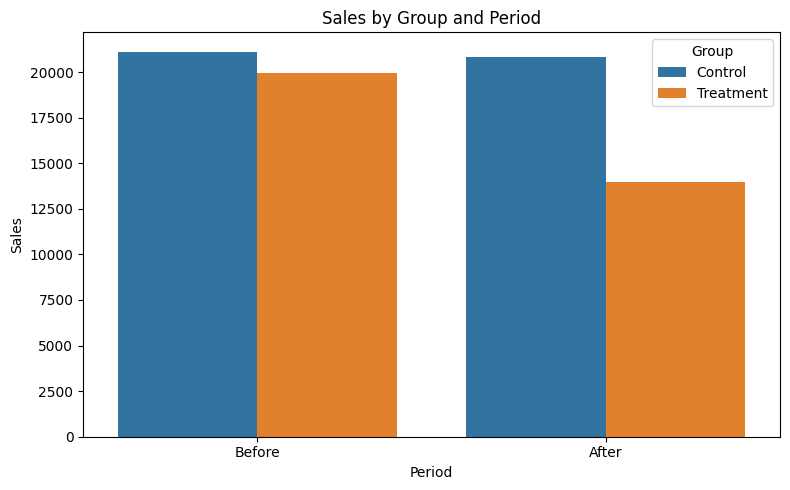

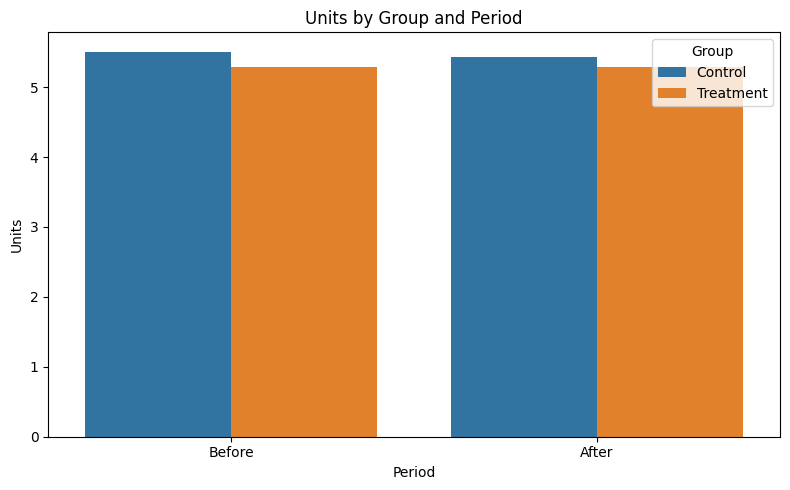

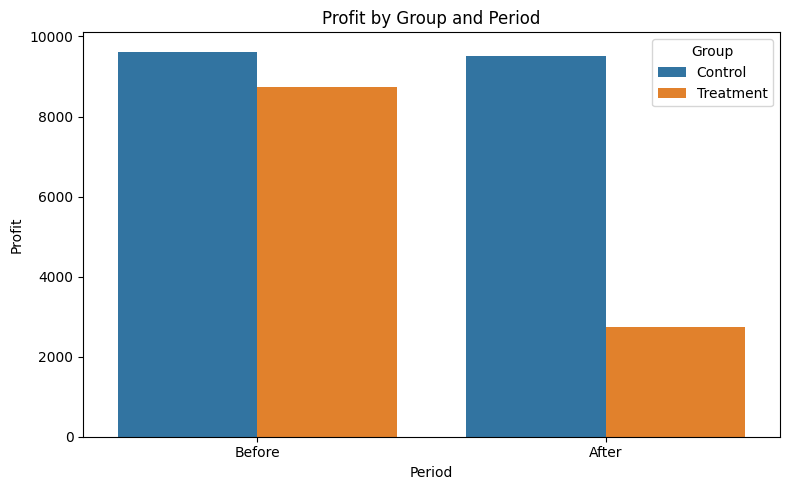

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("figures", exist_ok=True)
os.makedirs('results', exist_ok=True)
df['group'] = df['treatment'].map({0: 'Control', 1: 'Treatment'})
df['period'] = df['post'].map({0: 'Before', 1: 'After'})
order = ['Before', 'After']

metrics = ['sales', 'units', 'profit']
for var in metrics:
    summary = df.groupby(['group', 'period'])[var].mean().reset_index()
    summary.to_csv(f'results/summary_{var}.csv', index=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=summary, x='period', y=var, hue='group', order=order, errorbar=None)
    plt.title(f'{var.capitalize()} by Group and Period')
    plt.ylabel(var.capitalize())
    plt.xlabel('Period')
    plt.legend(title='Group')
    plt.tight_layout()
    plt.savefig(f'figures/{var}_did_plot.png')
    plt.show()


## 3. 回帰分析（DID）
差分の差分法により、セール施策の効果を定量的に検証します。結果はファイルとして保存します。

In [3]:
import statsmodels.formula.api as smf

def did_regression(target):
    result = smf.ols(f'{target} ~ treatment + post + treatment:post', data=df).fit()
    with open(f'results/did_result_{target}.txt', 'w') as f:
        f.write(result.summary().as_text())

for variable in ['sales', 'units', 'profit', 'profit_rate']:
    did_regression(variable)

## 4. 考察
セール施策は、売上・販売点数・利益・利益率のいずれにおいても、Treatment群におけるAfter期で顕著な増加が確認されました（詳細はDID結果を参照）。この仮想実験では、セールがポジティブな因果効果を持つことを示唆しています。